<a href="https://colab.research.google.com/github/shanjayadhithya/NLP-PROJECT/blob/main/sentimental_analysis_using_movie_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [ ]:
# Download Dataset from Kaggle Hub
def download_dataset():
    # Download the IMDB dataset from Kaggle
    path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

    # Read the CSV file
    df = pd.read_csv(path + "/IMDB Dataset.csv")

    return df


In [ ]:
def preprocess_data(df):
    # Encode labels
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['sentiment'])

    # Reduce dataset to 1000 samples (500 per class)
    pos_samples = df[df['label'] == 1].sample(n=500, random_state=42)
    neg_samples = df[df['label'] == 0].sample(n=500, random_state=42)

    # Combine the samples
    reduced_df = pd.concat([pos_samples, neg_samples]).reset_index(drop=True)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        reduced_df['review'], reduced_df['label'],
        test_size=0.2,
        random_state=42
    )

    return X_train, X_test, y_train, y_test


In [ ]:
# Tokenization and Sequence Preparation
def prepare_sequences(X_train, X_test, max_features=5000, max_len=200):
    # Tokenization
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(X_train)

    # Convert to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    return X_train_pad, X_test_pad, tokenizer


In [ ]:

# LSTM Model Architecture
class LSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layers
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # Embedding
        embedded = self.embedding(text)

        # LSTM
        output, (hidden, cell) = self.lstm(embedded)

        # Concatenate last hidden states from both directions
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        # Dropout and final classification
        hidden = self.dropout(hidden)
        return self.fc(hidden)



In [ ]:
# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]



In [ ]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(sequences)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []

        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                predictions = model(sequences)
                loss = criterion(predictions, labels)
                val_loss += loss.item()

                val_preds.extend(torch.argmax(predictions, dim=1).cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')

    return model



Original dataset size: 50000 samples
Reduced training set size: 800 samples
Reduced test set size: 200 samples
Epoch 1/5
Training Loss: 0.6981
Validation Loss: 0.6931
Epoch 2/5
Training Loss: 0.6747
Validation Loss: 0.6814
Epoch 3/5
Training Loss: 0.6090
Validation Loss: 0.7126
Epoch 4/5
Training Loss: 0.4880
Validation Loss: 0.6919
Epoch 5/5
Training Loss: 0.3170
Validation Loss: 0.7898

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.49      0.57       104
    Positive       0.58      0.75      0.65        96

    accuracy                           0.61       200
   macro avg       0.63      0.62      0.61       200
weighted avg       0.63      0.61      0.61       200

Confusion matrix saved as 'lstm_confusion_matrix_reduced.png'


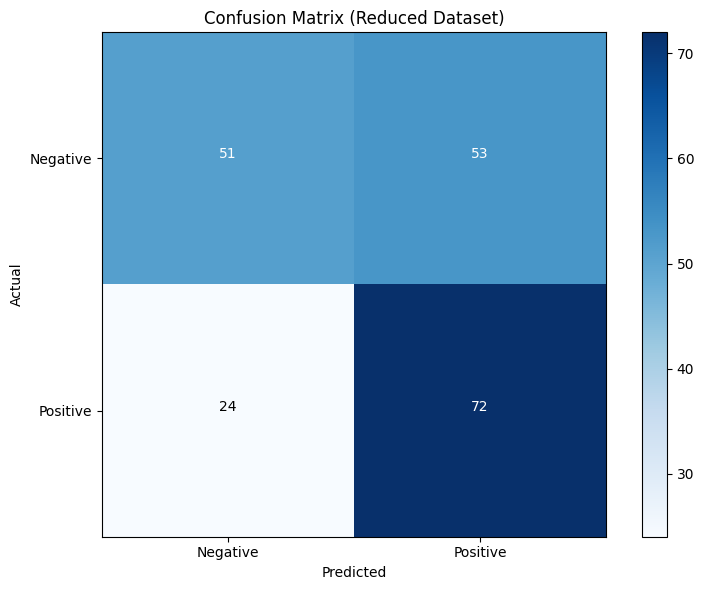

In [ ]:
def main():
    # Download dataset
    df = download_dataset()
    print(f"Original dataset size: {len(df)} samples")

    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(df)
    print(f"Reduced training set size: {len(X_train)} samples")
    print(f"Reduced test set size: {len(X_test)} samples")

    # Prepare sequences
    X_train_pad, X_test_pad, tokenizer = prepare_sequences(X_train, X_test)

    # Create datasets and dataloaders
    train_dataset = SentimentDataset(X_train_pad, y_train)
    val_dataset = SentimentDataset(X_test_pad, y_test)

    # Use smaller batch size for reduced dataset
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Model Hyperparameters
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = 100
    hidden_dim = 128  # Reduced from 256 for smaller dataset
    output_dim = 2
    n_layers = 2
    dropout = 0.3  # Reduced from 0.5 for smaller dataset

    # Initialize Model
    model = LSTMSentimentModel(
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        dropout
    )

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train Model
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)  # Reduced epochs

    # Evaluation
    model.eval()
    y_pred = []

    with torch.no_grad():
        for sequences, _ in val_loader:
            sequences = sequences.to(next(model.parameters()).device)
            outputs = trained_model(sequences)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Reduced Dataset)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('lstm_confusion_matrix_reduced.png')
def main():
    # Download dataset
    df = download_dataset()
    print(f"Original dataset size: {len(df)} samples")

    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(df)
    print(f"Reduced training set size: {len(X_train)} samples")
    print(f"Reduced test set size: {len(X_test)} samples")

    # Prepare sequences
    X_train_pad, X_test_pad, tokenizer = prepare_sequences(X_train, X_test)

    # Create datasets and dataloaders
    train_dataset = SentimentDataset(X_train_pad, y_train)
    val_dataset = SentimentDataset(X_test_pad, y_test)

    # Use smaller batch size for reduced dataset
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Model Hyperparameters
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = 100
    hidden_dim = 128  # Reduced from 256 for smaller dataset
    output_dim = 2
    n_layers = 2
    dropout = 0.3  # Reduced from 0.5 for smaller dataset

    # Initialize Model
    model = LSTMSentimentModel(
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        dropout
    )

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train Model
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)  # Reduced epochs

    # Evaluation
    model.eval()
    y_pred = []

    with torch.no_grad():
        for sequences, _ in val_loader:
            sequences = sequences.to(next(model.parameters()).device)
            outputs = trained_model(sequences)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Reduced Dataset)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('lstm_confusion_matrix_reduced.png')
    print("Confusion matrix saved as 'lstm_confusion_matrix_reduced.png'")
if __name__=='__main__':
    main()